In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Global variables

In [2]:
DIR_TFRECORDS = 'data_small_tfrecords'

IMG_H, IMG_W = 608, 608

In [3]:
## Input function for estimator

def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'target': tf.FixedLenFeature(shape=(), dtype=tf.string),
    }
    
    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)
    
    # decode image
    img = tf.decode_raw(parsed['img'], tf.float32)
    img = tf.reshape(img, [IMG_H, IMG_W, 3])
    
    # decode label
    target = tf.decode_raw(parsed['target'], tf.float32)
    target = tf.reshape(target, [1, 5])
    
    return {'img': img}, target
    
def input_fn_train(data_file):
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    
    return features, labels

In [4]:
tf.reset_default_graph()
f, t = input_fn_train(DIR_TFRECORDS+'/0.tfrecords')

with tf.Session() as sess:
    f, t = sess.run([f,t])

In [5]:
t.shape

(1, 5)

In [7]:
l = t

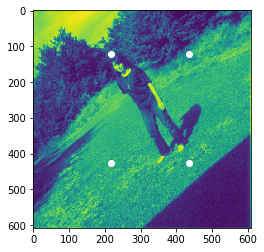

In [9]:
plt.imshow(f['img'][:,:,0])
plt.scatter((l[0,1]-l[0,3]/2)*IMG_W, (l[0,0]-l[0,2]/2)*IMG_H, color='w')
plt.scatter((l[0,1]-l[0,3]/2)*IMG_W, (l[0,0]+l[0,2]/2)*IMG_H, color='w')
plt.scatter((l[0,1]+l[0,3]/2)*IMG_W, (l[0,0]-l[0,2]/2)*IMG_H, color='w')
plt.scatter((l[0,1]+l[0,3]/2)*IMG_W, (l[0,0]+l[0,2]/2)*IMG_H, color='w')
plt.show()